# SVGP ensembles and sparse SVGP on the banana dataset

This notebook contains the code to generate figures 2 and 4. It takes a minute or so to run.


In [1]:
import numpy as np
import gpflow
import guepard
import matplotlib.pyplot as plt
import scipy
import scipy.io as sio

from gpflow.utilities import print_summary

# The lines below are specific to the notebook format
%matplotlib inline
plt.rcParams["figure.figsize"] = (12, 6)
from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height: 150em; }</style>"));

/Users/nicolasdurrande/projects/guepard/.venv/lib/python3.9/site-packages/gpflow/experimental/utils.py:42: UserWarning: You're calling gpflow.experimental.check_shapes.decorator.check_shapes which is considered *experimental*. Expect: breaking changes, poor documentation, and bugs.
  warn(
/Users/nicolasdurrande/projects/guepard/.venv/lib/python3.9/site-packages/gpflow/experimental/utils.py:42: UserWarning: You're calling gpflow.experimental.check_shapes.inheritance.inherit_check_shapes which is considered *experimental*. Expect: breaking changes, poor documentation, and bugs.
  warn(
/Users/nicolasdurrande/projects/guepard/.venv/lib/python3.9/site-packages/gpflow/experimental/utils.py:42: UserWarning: You're calling gpflow.experimental.check_shapes.checker.ShapeChecker.__init__ which is considered *experimental*. Expect: breaking changes, poor documentation, and bugs.
  warn(


## Figure 2: SVGP ensembles on the banana dataset

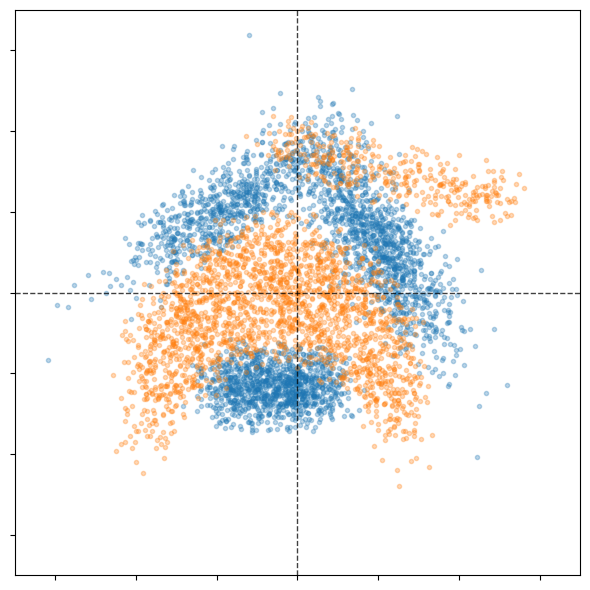

In [2]:
data = sio.loadmat('../../data/banana.mat')
Y = data['banana_Y']
X = data['banana_X']

x1_lim = [-3.5, 3.5]
x2_lim = [-3.5, 3.5]

fig, ax = plt.subplots(figsize=(6, 6))

ax.plot(X[Y[:, 0] == 0, 0], X[Y[:, 0] == 0, 1], 'o', color="C0", ms=3, alpha=0.3, label="$y=0$")
ax.plot(X[Y[:, 0] == 1, 0], X[Y[:, 0] == 1, 1], 'o', color="C1", ms=3, alpha=0.3, label="$y=1$")
ax.axhline(0, color='k', linestyle="dashed", alpha=0.75, linewidth=1)
ax.axvline(0, color='k', linestyle="dashed", alpha=0.75, linewidth=1)

ax.set_xlim(x1_lim)
ax.set_ylim(x2_lim)

ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])

plt.tight_layout()
plt.savefig("figures/banana_data.pdf")

We then split the dataset in four, with one subset per quadrant of the input space:

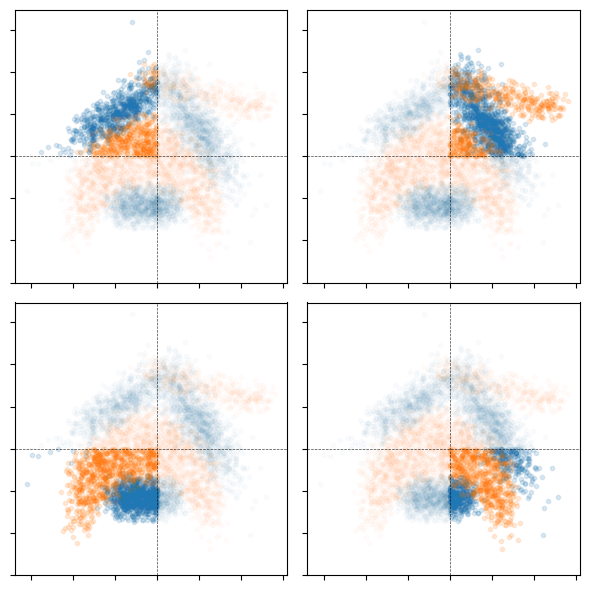

In [3]:
# Compute masks for the four quadrants
maskNE = np.logical_and(X[:, 0] < 0, X[:, 1] >= 0) 
maskNW = np.logical_and(X[:, 0] >= 0, X[:, 1] >= 0) 
maskSE = np.logical_and(X[:, 0] < 0, X[:, 1] < 0) 
maskSW = np.logical_and(X[:, 0] >= 0, X[:, 1] < 0) 
masks = [maskNE, maskNW, maskSE, maskSW]

fig, axes = plt.subplots(2, 2, figsize=(6, 6))
for i in range(2):
    for j in range(2):
        k = 2 * i + j

        X_ = X[masks[k], :]
        Y_ = Y[masks[k], :]
        axes[i, j].plot(X_[Y_[:, 0] == 0, 0], X_[Y_[:, 0] == 0, 1], 'o', color="C0", ms=3, alpha=0.13, label="$y=0$")
        axes[i, j].plot(X_[Y_[:, 0] == 1, 0], X_[Y_[:, 0] == 1, 1], 'o', color="C1", ms=3, alpha=0.13, label="$y=1$")

        axes[i, j].plot(X[Y[:, 0] == 0, 0], X[Y[:, 0] == 0, 1], 'o', color="C0", ms=3, alpha=0.02, label="$y=0$")
        axes[i, j].plot(X[Y[:, 0] == 1, 0], X[Y[:, 0] == 1, 1], 'o', color="C1", ms=3, alpha=0.02, label="$y=1$")

        axes[i,j].axhline(0, color='k', linestyle="dashed", alpha=0.75, linewidth=.5)
        axes[i,j].axvline(0, color='k', linestyle="dashed", alpha=0.75, linewidth=.5)

        axes[i, j].set_xticks(np.arange(-3, 4))
        axes[i, j].set_yticks(np.arange(-3, 4))
        axes[i, j].axes.xaxis.set_ticklabels([])
        axes[i, j].axes.yaxis.set_ticklabels([])

plt.tight_layout()


We build an SVGP model for each data subset, with 15 inducing variables for each of them. Note that all submodels share the same kernel and that the kernel parameters are fixed.

In [4]:
kernel = gpflow.kernels.Matern32(variance=50., lengthscales=[3., 3.])
gpflow.set_trainable(kernel, False)
lik = gpflow.likelihoods.Bernoulli()
mean_function = gpflow.mean_functions.Zero()

M = []
for mask in masks:
    X_ = X[mask, :]
    Y_ = Y[mask, :]
    Z = scipy.cluster.vq.kmeans(X_, 15)[0] # the locations of the inducing variables are initialised with k-means

    m = gpflow.models.SVGP(inducing_variable=Z, likelihood=lik, kernel=kernel, mean_function=mean_function)
    opt = gpflow.optimizers.Scipy()
    opt_logs = opt.minimize(m.training_loss_closure((X_, Y_)), m.trainable_variables);
    M += [m]
    

2022-10-17 12:09:03.940974: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2022-10-17 12:09:06.072766: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Let's plot the submodels predictions in the data space.

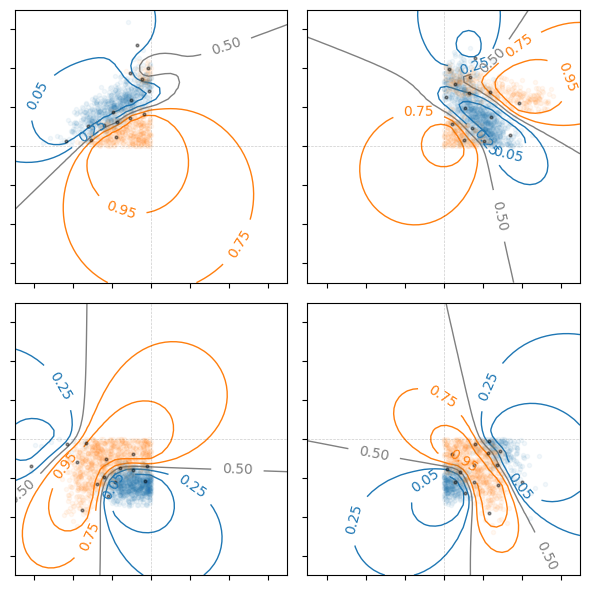

In [5]:
x1_grid = np.linspace(*x1_lim, 50)
x2_grid = np.linspace(*x2_lim, 50)
X1_grid, X2_grid = np.meshgrid(x1_grid, x2_grid) 
Xtest = np.hstack([X1_grid.reshape(-1, 1), X2_grid.reshape(-1, 1)])

fig, axes = plt.subplots(2, 2, figsize=(6, 6))
for i in range(2):
    for j in range(2):
        k = 2 * i + j
        
        axes[i,j].axhline(0, color='k', linestyle="dashed", alpha=0.2, linewidth=.5)
        axes[i,j].axvline(0, color='k', linestyle="dashed", alpha=0.2, linewidth=.5)

        X_ = X[masks[k], :]
        Y_ = Y[masks[k], :]
        axes[i, j].plot(X_[Y_[:, 0] == 0, 0], X_[Y_[:, 0] == 0, 1], 'o', color="C0", ms=3, alpha=0.05, label="$y=0$")
        axes[i, j].plot(X_[Y_[:, 0] == 1, 0], X_[Y_[:, 0] == 1, 1], 'o', color="C1", ms=3, alpha=0.05, label="$y=1$")
        
        Z = M[k].inducing_variable.Z
        axes[i, j].plot(Z[:, 0], Z[:, 1], "ko", ms=2., alpha=.4)

        Ytest, _ = M[k].predict_y(Xtest)
        cs = axes[i, j].contour(X1_grid, X2_grid, np.reshape(Ytest, (50, 50)), linewidths=1, colors=["C0", "C0", "grey","C1", "C1"],
                        levels=[0.05, 0.25, 0.5, 0.75, 0.95], zorder=0)
        axes[i, j].clabel(cs, inline=1, fontsize=10, fmt='%1.2f')


        axes[i, j].set_xticks(np.arange(-3, 4))
        axes[i, j].set_yticks(np.arange(-3, 4))
        axes[i, j].axes.xaxis.set_ticklabels([])
        axes[i, j].axes.yaxis.set_ticklabels([])

plt.tight_layout()
plt.savefig("figures/banana_submodels.pdf")

We can also plot the submodel predictions in the latent space

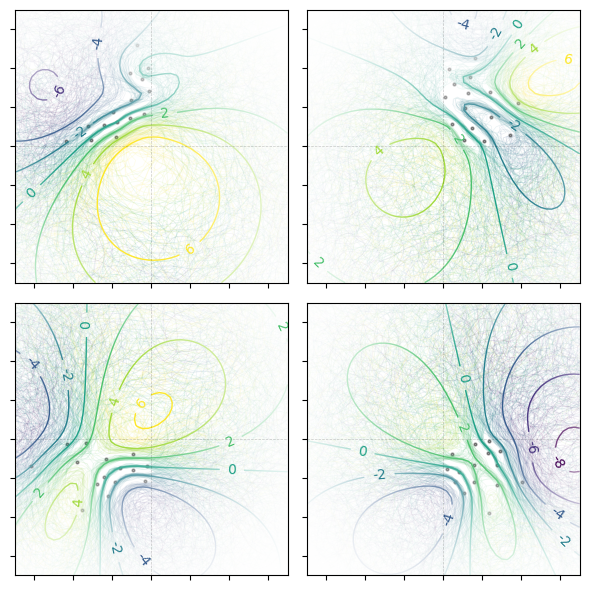

In [6]:
def plot_latent(Mtest, Vtest_full, X1_grid, X2_grid, ax, num_sample=100):
    Vtest_full = Vtest_full.numpy()[0, :, :]
    Vtest = np.diag(Vtest_full).reshape((50, 50))

    # plot samples
    if num_sample != 0:
        Fp = np.random.multivariate_normal(Mtest.numpy().flatten(), Vtest_full, num_sample).T
        for k in range(num_sample):
            ax.contour(X1_grid, X2_grid, np.reshape(Fp[:, k], (50, 50)),
                       levels=np.arange(-4, 4)*2, alpha=0.1,
                       linewidths= .5)

    # plot mean
    cs = ax.contour(X1_grid, X2_grid, np.reshape(Mtest, (50, 50)),
                           levels=np.arange(-4, 4)*2,
                           linewidths= 1)
    ax.clabel(cs, inline=1, fontsize=10, fmt='%1.f')

    # add transparency where predictions are uncertain
    alphas = np.minimum(1., Vtest/np.max(Vtest))
    ax.imshow(np.ones((50, 50)), cmap="binary", alpha=alphas, zorder=2, extent=(*x1_lim, *x2_lim), interpolation="bilinear")

fig, axes = plt.subplots(2, 2, figsize=(6, 6))
for i in range(2):
    for j in range(2):
        k = 2 * i + j
        
        Z = M[k].inducing_variable.Z
        axes[i, j].plot(Z[:, 0], Z[:, 1], "ko", ms=2., alpha=.4)
        
        Ftest, Vtest_full = M[k].predict_f(Xtest, full_cov=True)
        plot_latent(Ftest, Vtest_full, X1_grid, X2_grid, axes[i,j], num_sample=50)

        axes[i,j].axhline(0, color='k', linestyle="dashed", alpha=0.2, linewidth=.5)
        axes[i,j].axvline(0, color='k', linestyle="dashed", alpha=0.2, linewidth=.5)

        axes[i, j].set_xticks(np.arange(-3, 4))
        axes[i, j].set_yticks(np.arange(-3, 4))
        axes[i, j].axes.xaxis.set_ticklabels([])
        axes[i, j].axes.yaxis.set_ticklabels([])

plt.tight_layout()
plt.savefig("figures/banana_sublatents.pdf")

We can now use the equivalent observation framework to merge these four submodels

In [7]:
m_agg = guepard.EquivalentObsEnsemble(M)
Ftest, Vtest_full = m_agg.predict_f(Xtest, full_cov=True)
Ytest = m_agg.predict_y(Xtest)[0]

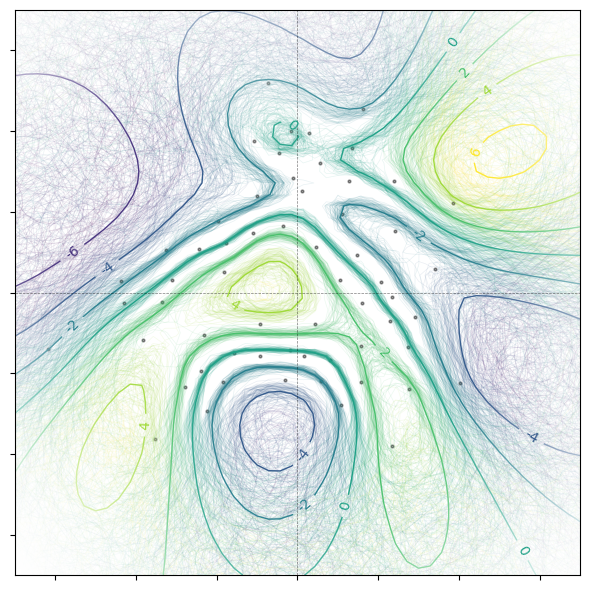

In [8]:
fig, ax = plt.subplots(figsize=(6, 6))

[plt.plot(m.inducing_variable.Z[:, 0], m.inducing_variable.Z[:, 1], "ko", ms=2., alpha=.4) for m in m_agg.models]

plot_latent(Ftest, Vtest_full, X1_grid, X2_grid, ax, num_sample=100)

ax.axhline(0, color='k', linestyle="dashed", alpha=0.5, linewidth=.5)
ax.axvline(0, color='k', linestyle="dashed", alpha=0.5, linewidth=.5)

ax.set_xlim(x1_lim)
ax.set_ylim(x2_lim)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])

plt.tight_layout()
plt.savefig("figures/banana_mergedlatents.pdf")


For comparison we fit an SVGP model with the same kernel, same inducing location Z, but an optimised distribution for the inducing variables.

In [9]:
import time
maxiter = 1000

def callback(x):
    global times
    global traces
    times += [time.time()]
    traces += [training_loss().numpy()]

Z = np.vstack([m.inducing_variable.Z for m in m_agg.models])
q_mu, q_sigma = None, None 
q_sqrt = None

m_svgp = gpflow.models.SVGP(inducing_variable=Z, likelihood=lik, kernel=kernel, mean_function=mean_function,
                      q_mu=q_mu, q_sqrt=q_sqrt, whiten=False)
gpflow.set_trainable(m_svgp.inducing_variable, False)

# Optimising the model. 
# Note that we record the optim traces, they will be compared to an sparse SVGP down the line
traces = []
times = []
training_loss = m_svgp.training_loss_closure((X, Y))
opt = gpflow.optimizers.Scipy()
opt_logs = opt.minimize(training_loss, m_svgp.trainable_variables, callback=callback, options={'maxiter':maxiter})

Ysvgp = m_svgp.predict_y(Xtest)[0]

Traces_svgp = -np.array(traces)
Times_svgp = np.array(times) - times[0]


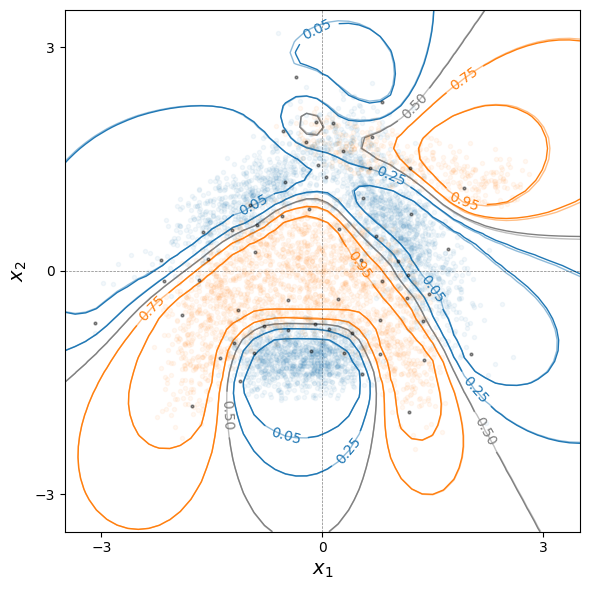

In [10]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.axhline(0, color='k', linestyle="dashed", alpha=0.5, linewidth=.5)
ax.axvline(0, color='k', linestyle="dashed", alpha=0.5, linewidth=.5)

ax.plot(X[Y[:, 0] == 0, 0], X[Y[:, 0] == 0, 1], 'o', color="C0", ms=3, alpha=0.05, label="$y=0$")
ax.plot(X[Y[:, 0] == 1, 0], X[Y[:, 0] == 1, 1], 'o', color="C1", ms=3, alpha=0.05, label="$y=1$")

cs = ax.contour(X1_grid, X2_grid, np.reshape(Ysvgp, (50, 50)), linewidths=1, colors=["C0", "C0", "grey","C1", "C1"],
                        levels=[0.05, 0.25, 0.5, 0.75, 0.95], zorder=0, alpha=.5)

cs = ax.contour(X1_grid, X2_grid, np.reshape(Ytest, (50, 50)), linewidths=1, colors=["C0", "C0", "grey","C1", "C1"],
                        levels=[0.05, 0.25, 0.5, 0.75, 0.95], zorder=0)

ax.clabel(cs, inline=1, fontsize=10, fmt='%1.2f')

plt.plot(m_svgp.inducing_variable.Z[:, 0], m_svgp.inducing_variable.Z[:, 1], "ko", ms=2., alpha=.4)
ax.set_xlabel("$x_1$", fontsize=14)
ax.set_ylabel("$x_2$", fontsize=14)
ax.set_xlim(x1_lim)
ax.set_ylim(x2_lim)
ax.axes.xaxis.set_ticks([-3, 0, 3])
ax.axes.yaxis.set_ticks([-3, 0, 3])

plt.tight_layout()
plt.savefig("figures/banana_models.pdf")

we can plot the absolute error

max absolute error 0.053632995565342734


(-3.5, 3.5)

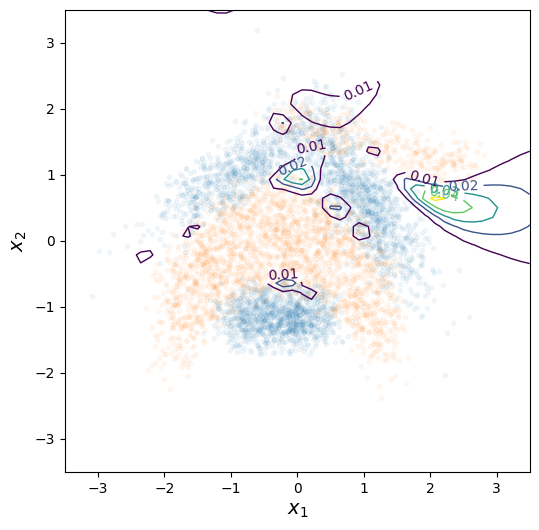

In [11]:
error = (Ytest- Ysvgp).numpy().flatten()
print("max absolute error", np.max(np.abs(error)))


fig, ax = plt.subplots(figsize=(6, 6))

ax.plot(X[Y[:, 0] == 0, 0], X[Y[:, 0] == 0, 1], 'o', color="C0", ms=3, alpha=0.05, label="$y=0$")
ax.plot(X[Y[:, 0] == 1, 0], X[Y[:, 0] == 1, 1], 'o', color="C1", ms=3, alpha=0.05, label="$y=1$")

cs = ax.contour(X1_grid, X2_grid, np.reshape(np.abs(error), (50, 50)), linewidths=1, levels=[0.01, 0.02, 0.03, 0.04, 0.05])
ax.clabel(cs, inline=1, fontsize=10, fmt='%1.2f')

ax.set_xlabel("$x_1$", fontsize=14)
ax.set_ylabel("$x_2$", fontsize=14)
ax.set_xlim(x1_lim)
ax.set_ylim(x2_lim)

## Figure 4: Further training under a unified SVGP ELBO

Instead of training separately the variational parameters of the submodels, we now explore how much the model can be improved by retraining them under a unifed ELBO corresponding to a sparse parametrisation in the precision space.

In [12]:
Zs, q_mus, q_sqrts = guepard.utilities.init_ssvgp_with_ensemble(m_agg.models, add_jitter=True) 
m_ssvgp = guepard.SparseSVGP(kernel, lik, Zs, q_mus, q_sqrts, whiten=False)
gpflow.set_trainable(m_ssvgp.inducing_variable, False)

traces = []
times = []
training_loss = m_ssvgp.training_loss_closure((X, Y), compile=True)
opt = gpflow.optimizers.Scipy()
opt.minimize(training_loss, m_ssvgp.trainable_variables, callback=callback, options={'maxiter':maxiter})

Traces_ssvgp = -np.array(traces)
Times_ssvgp = np.array(times) - times[0]


Instructions for updating:
Do not call `graph_parents`.


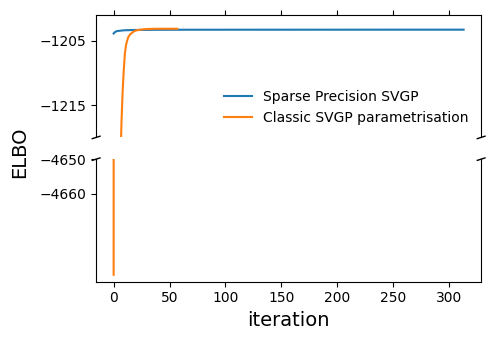

In [13]:
f, (ax, ax2) = plt.subplots(2, 1, figsize=(5, 3.5))
delta=20
# plot the same data on both axes
ax.plot(Traces_ssvgp, "C0", label="Sparse Precision SVGP")
ax.plot(Traces_svgp, "C1", label="Classic SVGP parametrisation")
ax.set_ylim((-1200 - delta, -1201))
ax.legend(frameon=False)
ax.set_yticks([ -1215, -1205])

ax2.plot(Traces_ssvgp, "C0", label="Sparse Precision SVGP")
ax2.plot(Traces_svgp, "C1", label="Classic SVGP parametrisation")
ax2.set_ylim((np.min(Traces_svgp)-2,np.min(Traces_svgp)+delta - 3))
ax2.set_yticks([-4660, -4650])
ax2.set_xlabel("iteration", fontsize=14)
ax2.set_ylabel(" ", fontsize=14)

ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax.xaxis.tick_top()
ax.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

d = .010  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', linewidth=1., clip_on=False)
ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

f.text(0.02, 0.55, 'ELBO', fontsize=14, va='center', rotation='vertical')
plt.tight_layout()
plt.savefig('figures/sparse_precision_SVGP_traces.pdf')

In [14]:
print("SSVGP trace (init, converged): ", np.min(Traces_ssvgp), np.max(Traces_ssvgp))
print("SVGP trace (init, converged): ", np.min(Traces_svgp), np.max(Traces_svgp))

print(f"SSVGP requires {Traces_ssvgp.shape[0] / Traces_svgp.shape[0]:.2f} times more iterations")

SSVGP trace (init, converged):  -1203.8862172857218 -1203.2960306395432
SVGP trace (init, converged):  -4683.377780018036 -1203.1536862452826
SSVGP requires 5.41 times more iterations


In [15]:
print('times per iter SSVGP iteration:', Times_ssvgp[-1] / Traces_ssvgp.shape)
print('times per iter SVGP iteration:', Times_svgp[-1] / Traces_svgp.shape)

print("comparing the number of variational parameters:", 4 * (15 + (15 * 16)/2), "vs", 60 + (60 * 61)/2)

times per iter SSVGP iteration: [0.02116962]
times per iter SVGP iteration: [0.01338837]
comparing the number of variational parameters: 540.0 vs 1890.0
